<details>
<summary> </summary>

```{toctree}
:maxdepth: 2
:caption: Installation

../../installation
```

```{toctree}
:maxdepth: 2
:caption: API

../../simvi/api
../../scshift/index
```

```{toctree}
:maxdepth: 2
:caption: Tutorials

SIMVI_tutorial_MERFISH
scShift_tutorial_Blood```
</details>

# scShift tutorial on blood data

In this tutorial, we illustrate the use of a trained scShift blood model to analyze pathogen stimulation dataset from Oelen et. al (2022).

## Load trained scShift model

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

from scshift import scShift

# Change the directories of adata and model to your local directories.

adata = sc.read_h5ad('train_blood.h5ad')

scShift.get_pert(adata,drug_label='sm_name',dose_label ='dose_uM', ct_drug='Dimethyl Sulfoxide')
scShift.setup_anndata(adata, batch_key='assay',labels_key = 'sm_name')
model = scShift.load('scshift_blood', adata)

Global seed set to 0
/app/home/mingze/MetaVI_project/pertvi/model/pertvi.py:439: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = df * adata.obs[dose_label][:,None]
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Generating sequential column names                                                                        
INFO     File trained_models/blood_50_new6/model.pt already downloaded                                             


## Train a scShift model from scratch

The code for training this model is provided as follows. Instead of training a new model (which takes quite some time), we recommend use our trained model. For purposes beyond the tutorial, we would also recommended you to run (or even engineer!) the model optimization.

In [ ]:
# Model training, may need to change the use_gpu option

#model = PertVI(adata,n_layers=2,n_latent=100,n_hidden=1000,lam_l0=0.2,lam_l1=0,kl_weight=1,lam_corr=200,use_observed_lib_size=True)
#model.train(
#    train_size=0.9,
#    use_gpu=4,
#    batch_size=400,
#    max_epochs=50,
#    lr = 1e-3,
#    weight_decay = 1e-4,
#    n_samples_per_label = 2,
#)

## Zero-shot analysis by scShift

We next input the pathogen stimulation dataset and use the scShift model to generate unperturbed and biological embeddings in a zero-shot manner.

In [2]:
# Load pathogen stimulation dataset, change directory
adata_pathogen = sc.read_h5ad('1M_v3preprocessed.h5ad')
adata_pathogen

AnnData object with n_obs × n_vars = 302598 × 23269
    obs: 'assignment', 'timepoint', 'chem', 'cell_type', 'cell_type_lowerres'

In [5]:
## use trained model to generate embedding, first align several fields


model.prepare_query_anndata(adata_pathogen,model)


adata_pathogen.obsm['pert'] = np.zeros([adata_pathogen.shape[0],adata.obsm['pert'].shape[1]])
adata_pathogen.obs['sm_name'] = adata.obs['sm_name'][0]
adata_pathogen.obs['assay'] = "10x 3' v3"

adata_pathogen.obsm['full_embedding'] = model.get_latent_representation(adata_pathogen,representation_kind='base')

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


We next used the dataset label encoding obtained from the training set to separate unperturbed and biological embeddings in the pathogen stimulation data.

In [6]:
## Need to change the directory of a

#adata.obsm['dataset_encoding'] = model.get_latent_representation(adata,representation_kind='pert')
#a = (adata.obsm['dataset_encoding']!=0).sum(axis=0).copy()

a = np.load('scshift_blood_a.npy')

adata_pathogen.obsm['ct_embedding'] = adata_pathogen.obsm['full_embedding'][:,a==0].copy()
adata_pathogen.obsm['bio_embedding'] = adata_pathogen.obsm['full_embedding'][:,a!=0].copy()
adata_pathogen

AnnData object with n_obs × n_vars = 302598 × 5036
    obs: 'assignment', 'timepoint', 'chem', 'cell_type', 'cell_type_lowerres', 'sm_name', 'assay', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'pert', 'full_embedding', 'ct_embedding', 'bio_embedding'

Here we show the UMAP of unperturbed and biological embeddings generated by scShift solely from gene expressions. Unperturbed embedding captures the cell type information, whereas the biological embedding captures the perturbation information.

2025-01-01 03:34:15.531536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


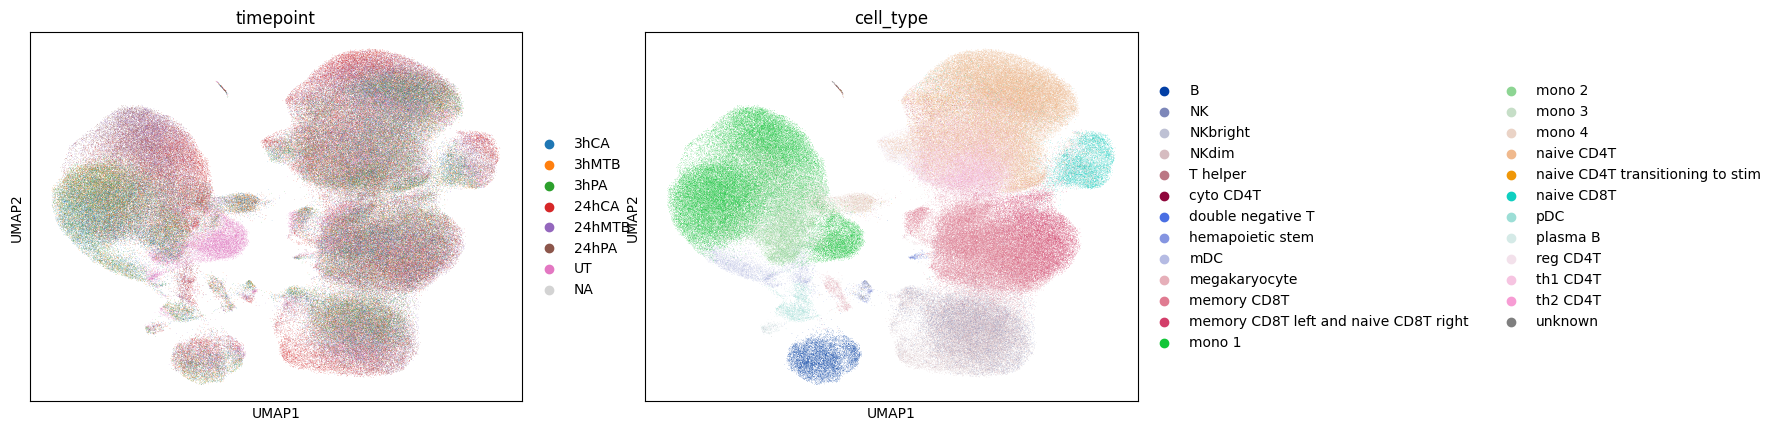

In [8]:
sc.pp.neighbors(adata_pathogen,use_rep='ct_embedding')
sc.tl.umap(adata_pathogen)
sc.pl.umap(adata_pathogen,color=['timepoint','cell_type'])

In [9]:
adata_pathogen.obsm['ct_umap'] = adata_pathogen.obsm['X_umap'].copy()

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


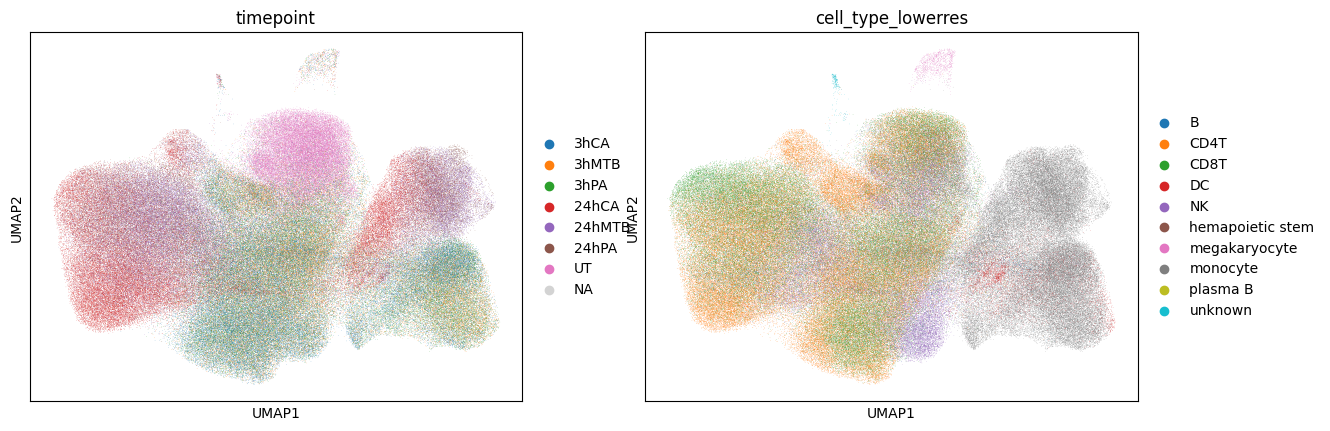

In [11]:
sc.pp.neighbors(adata_pathogen,use_rep='bio_embedding')
sc.tl.umap(adata_pathogen)
sc.pl.umap(adata_pathogen,color=['timepoint','cell_type_lowerres'])